In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import torch as th

adata = scv.datasets.dentategyrus()

scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.standard_clean_recipe(adata)

model = ltv.models.VAE(observed=2000, latent_dim=20 , zr_dim=3, h_dim=4, 
                       encoder_hidden=25)

epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100, learning_rate=1e-2,
                                      epochs=50, name='dentate_gyrus', grad_clip=100)

Global seed set to 0


Filtered out 10340 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
871 velocity genes used
epoch 0, full loss 168.215, val loss 108.757, recon MSE 2.438, traj MSE 0.612, reg loss -2.775
epoch 1, full loss 100.313, val loss 54.162, recon MSE 2.184, traj MSE 0.549, reg loss -3.364
epoch 2, full loss 54.867, val loss 8.897, recon MSE 1.792, traj MSE 0.531, reg loss -3.689
epoch 3, full loss 19.016, val loss -39.015, recon MSE 1.422, traj MSE 0.465, reg loss -3.519
epoch 4, full loss -6.933, val loss -86.468, recon MSE 1.132, traj MSE 0.451, reg loss -3.399
epoch 5, full loss -27.893, val loss -132.584, recon MSE 1.011,

In [2]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

In [3]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


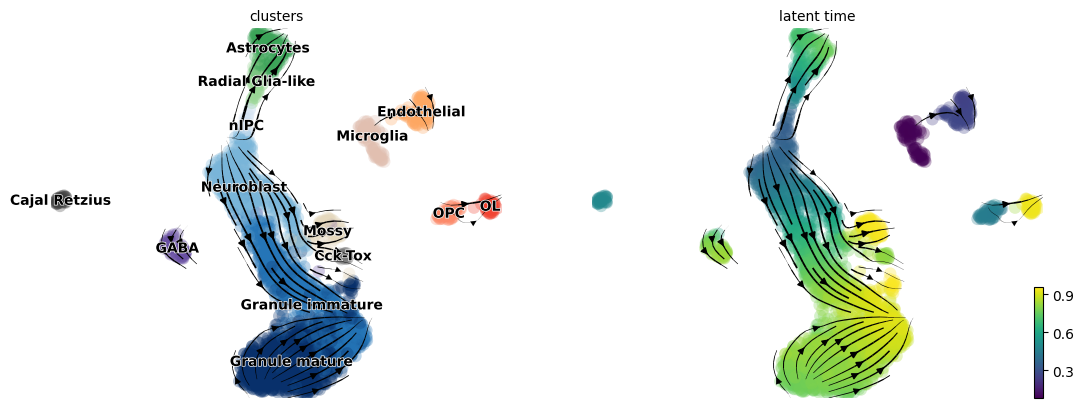

In [4]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['clusters','latent_time'])

saving figure to file ../figures/dentategyrus_model_umap_lineages.png


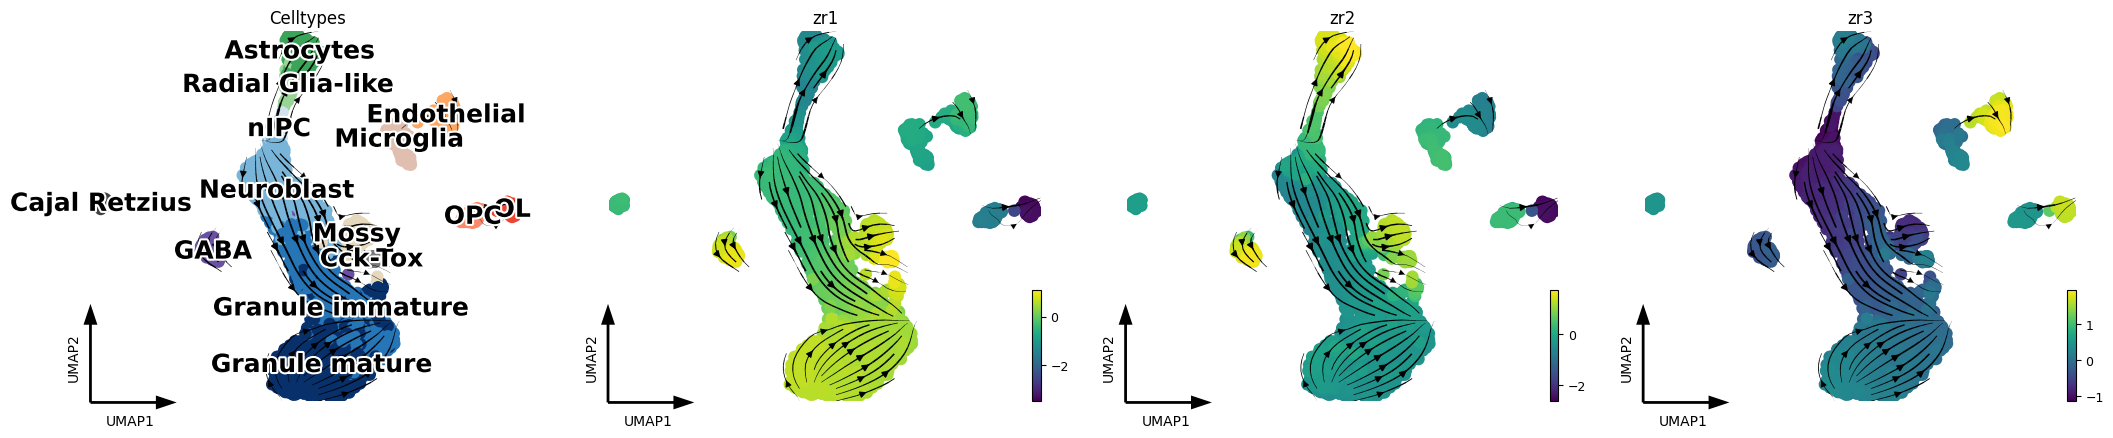

In [5]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
latent_adata.obs['zr3'] = latent_adata.obsm['zr'][:,2]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters', 'zr1', 'zr2', 'zr3'], 
                                 title=['Celltypes', 'zr1', 'zr2', 'zr3'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=12, frameon='artist',
                                save='../figures/dentategyrus_model_umap_lineages.png')

In [6]:
# save fit
latent_adata.write('../benchmark/real_data/fits/dentategyrus_latent_adata.h5ad')

In [7]:
dtg_edges = [
    ('OPC', 'OL'), ('Radial Glia-like', 'Astrocytes'),
    ('Neuroblast', 'Granule immature')]

scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
dtg_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                                      'clusters', 'spliced_velocity_pca', 
                                               dtg_edges, x_emb='X_pca', 
                                                      majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


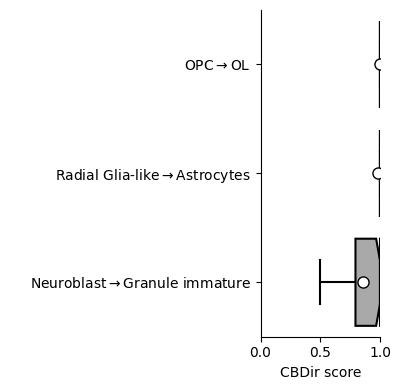

In [8]:
import matplotlib.pyplot as plt
ax=ltv.pl.transition_scores(dtg_pca, raw=True)
ax.set(xlim=(0,1))
plt.savefig('figures/dentategyrus_transitions.pdf')
plt.show()